In [1]:
import xarray as xr
base_dir = f'/mnt/lustre/koa/class/atmo449_class/students/team_1_flood_risk/'
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
import numpy as np
import os

hawaii_lat_bound, hawaii_lon_bound = slice(18, 23), slice(-161, -154)
dry_months, wet_months = [5,6,7,8,9,10], [1,2,3,4,11,12]

In [2]:
def plot_contourf(lat, lon, data, levels, cmap, ax, cbar=True, cbar_label=''):
    cf = ax.contourf(lon, lat, data, cmap=cmap, levels=levels, extend='both', transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(lon, lat, data, colors='k', linewidths=1, levels=levels[::2],
                    transform=ccrs.PlateCarree())
    # add contour labels
    lb = plt.clabel(cs, fontsize=14, inline=False, fmt='%0.1f');
    if cbar:
        cb = plt.colorbar(cf, shrink=0.6)
        cb.ax.set_title('', fontsize=3.5)
        cb.set_label(cbar_label, fontsize=10)
        cb.ax.tick_params(labelsize=10)

def geo_ylabel(ax, label, **kwargs):
    """
    Adds a y-axis-like label to a GeoAxes (or regular Axes).
    
    Parameters
    ----------
    ax : matplotlib Axes or GeoAxes
        Axis to which the label will be attached.
    label : str
        The label text.
    **kwargs : dict
        Extra text properties (e.g., fontsize, color, fontweight, etc.)
    """
    bbox = ax.get_position()
    fig = ax.figure

    # find vertical center of the axes
    y_center = (bbox.y0 + bbox.y1) / 2

    # place label just outside the left edge
    fig.text(
        bbox.x0 - 0.015,  # horizontal offset (tweak as needed)
        y_center,
        label,
        va='center', ha='right',
        rotation='vertical',
        **kwargs
    )


# ERA5

In [3]:
all_year_data = []
for year in tqdm(range(2007, 2025)):
    all_year_data.append(xr.open_dataset(f"{base_dir}/preprocessed_data/regridded_3hourly_ERA5/{year}.nc"))
ds_era5 = xr.concat(all_year_data, dim='time')
ds_era5['pr'] = ds_era5['tp'] * 1000 * 24 # m/h to mm/day

  0%|                                                                                                                                                                                                 | 0/18 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.86it/s]


In [5]:
ds_era5_all = ds_era5.assign_coords(lon=(ds_era5.lon + 180) % 360 - 180).sel(lat=hawaii_lat_bound, lon=hawaii_lon_bound)# "_all" as in all seasons

In [6]:
ds_era5_dry = ds_era5_all.sel(time=ds_era5_all.time.dt.month.isin(dry_months))
ds_era5_wet = ds_era5_all.sel(time=ds_era5_all.time.dt.month.isin(wet_months))

In [7]:
# annual mean
era5_annual_precip_rate_mean = ds_era5_all.mean(dim='time')['pr'].to_numpy()
era5_annual_precip_rate_std = ds_era5_all.std(dim='time')['pr'].to_numpy()
era5_annual_precip_rate_98 = ds_era5_all.quantile(dim='time', q=0.98)['pr'].to_numpy()

# seasonal mean (dry)
era5_dry_precip_rate_mean = ds_era5_dry.mean(dim='time')['pr'].to_numpy()
era5_dry_precip_rate_std = ds_era5_dry.std(dim='time')['pr'].to_numpy()
era5_dry_precip_rate_98 = ds_era5_dry.quantile(dim='time', q=0.98)['pr'].to_numpy()

# seasonal mean (wet)
era5_wet_precip_rate_mean = ds_era5_wet.mean(dim='time')['pr'].to_numpy()
era5_wet_precip_rate_std = ds_era5_wet.std(dim='time')['pr'].to_numpy()
era5_wet_precip_rate_98 = ds_era5_wet.quantile(dim='time', q=0.98)['pr'].to_numpy()

In [8]:
# accumulation
era5_accum_precip_3_hourly = ds_era5_all * (3 / 24)# convert rate (mm/day) to accumulation (mm over 3-hour)
era5_accum_precip_daily = era5_accum_precip_3_hourly.resample(time='1D').sum()

era5_annual_rainy_day_freq = (era5_accum_precip_daily > 1).mean(dim='time')['pr'].to_numpy()
era5_dry_rainy_day_freq = (era5_accum_precip_daily.sel(time=era5_accum_precip_daily.time.dt.month.isin(dry_months)) > 1).mean(dim='time')['pr'].to_numpy()
era5_wet_rainy_day_freq = (era5_accum_precip_daily.sel(time=era5_accum_precip_daily.time.dt.month.isin(wet_months)) > 1).mean(dim='time')['pr'].to_numpy()

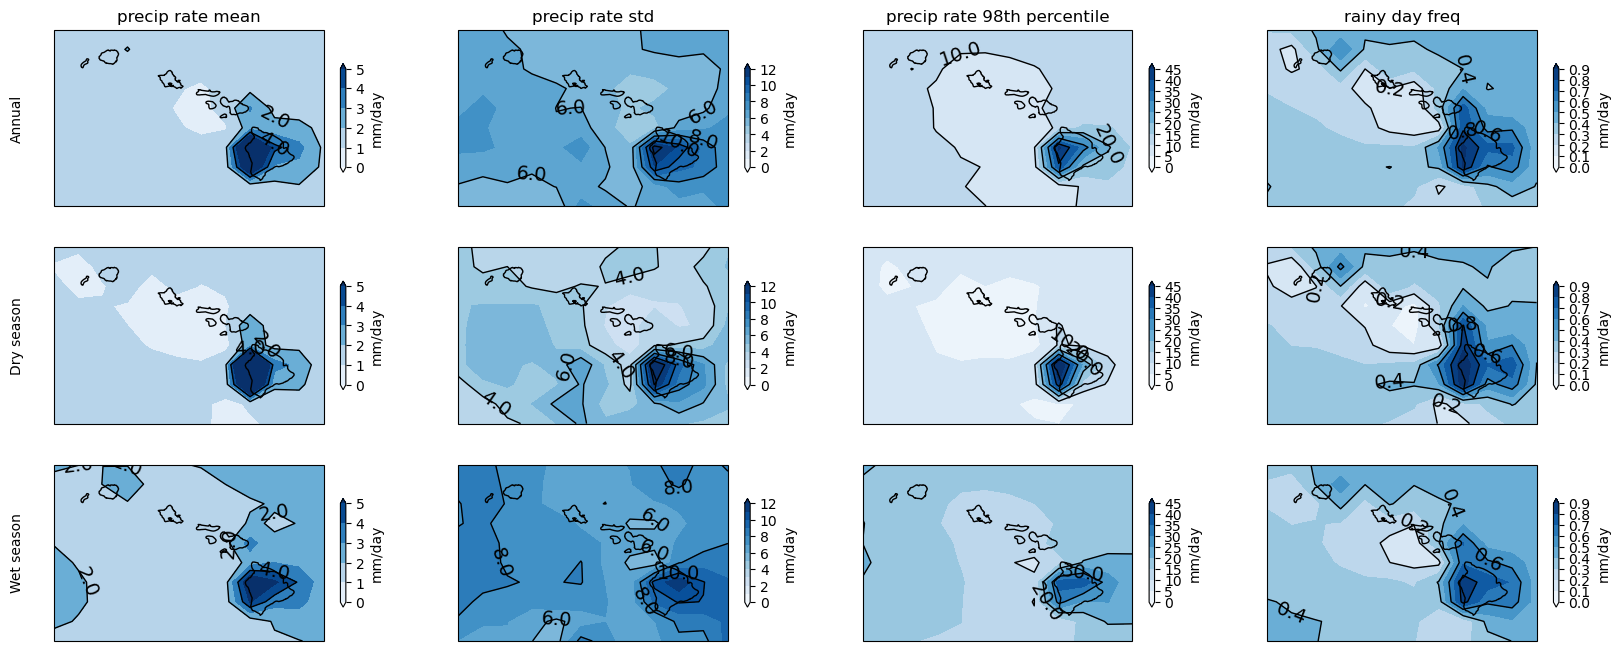

In [9]:
fig, axs = plt.subplots(3, 4, figsize=(20,8), subplot_kw=dict(projection=ccrs.PlateCarree()))
lat, lon = ds_era5_all.lat, ds_era5_all.lon
plot_contourf(ax=axs[0,0], lat=lat, lon=lon, data=era5_annual_precip_rate_mean, cmap='Blues', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[0,1], lat=lat, lon=lon, data=era5_annual_precip_rate_std, cmap='Blues', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[0,2], lat=lat, lon=lon, data=era5_annual_precip_rate_98, cmap='Blues', levels=np.arange(0, 50, 5), cbar_label='mm/day')
plot_contourf(ax=axs[0,3], lat=lat, lon=lon, data=era5_annual_rainy_day_freq, cmap='Blues', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')

plot_contourf(ax=axs[1,0], lat=lat, lon=lon, data=era5_dry_precip_rate_mean, cmap='Blues', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[1,1], lat=lat, lon=lon, data=era5_dry_precip_rate_std, cmap='Blues', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[1,2], lat=lat, lon=lon, data=era5_dry_precip_rate_98, cmap='Blues', levels=np.arange(0, 50, 5), cbar_label='mm/day')
plot_contourf(ax=axs[1,3], lat=lat, lon=lon, data=era5_dry_rainy_day_freq, cmap='Blues', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')

plot_contourf(ax=axs[2,0], lat=lat, lon=lon, data=era5_wet_precip_rate_mean, cmap='Blues', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[2,1], lat=lat, lon=lon, data=era5_wet_precip_rate_std, cmap='Blues', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[2,2], lat=lat, lon=lon, data=era5_wet_precip_rate_98, cmap='Blues', levels=np.arange(0, 50, 5), cbar_label='mm/day')
plot_contourf(ax=axs[2,3], lat=lat, lon=lon, data=era5_wet_rainy_day_freq, cmap='Blues', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')
[ax.coastlines() for ax in axs.flatten()]

geo_ylabel(axs[0,0], 'Annual')
geo_ylabel(axs[1,0], 'Dry season')
geo_ylabel(axs[2,0], 'Wet season')

fig.canvas.draw()
axs[0,0].set_title('precip rate mean')
axs[0,1].set_title('precip rate std')
axs[0,2].set_title('precip rate 98th percentile')
axs[0,3].set_title('rainy day freq')
pass

# GCM

In [17]:
# ds_gcm = xr.open_dataset(f"{base_dir}/raw_data/GFDL/GFDL_CM4C192_pr_hawaii_2007_2014.nc")
ds_gcm_historical = xr.open_dataset(f"{base_dir}/wasfia/GFDL_CM4C192_pr_hawaii_1981_2010.nc")
ds_gcm_historical_all = ds_gcm_historical.assign_coords(lon=(ds_gcm_historical.lon + 180) % 360 - 180).sel(lat=hawaii_lat_bound, lon=hawaii_lon_bound)# "_all" as in all seasons

In [18]:
ds_gcm_historical_dry = ds_gcm_historical_all.sel(time=ds_gcm_historical_all.time.dt.month.isin(dry_months))
ds_gcm_historical_wet = ds_gcm_historical_all.sel(time=ds_gcm_historical_all.time.dt.month.isin(wet_months))

In [19]:
# annual mean
gcm_historical_annual_precip_rate_mean = ds_gcm_historical_all.mean(dim='time')['pr'].to_numpy()
gcm_historical_annual_precip_rate_std = ds_gcm_historical_all.std(dim='time')['pr'].to_numpy()
gcm_historical_annual_precip_rate_98 = ds_gcm_historical_all.quantile(dim='time', q=0.98)['pr'].to_numpy()
# seasonal mean (dry)
gcm_historical_dry_precip_rate_mean = ds_gcm_historical_dry.mean(dim='time')['pr'].to_numpy()
gcm_historical_dry_precip_rate_std = ds_gcm_historical_dry.std(dim='time')['pr'].to_numpy()
gcm_historical_dry_precip_rate_98 = ds_gcm_historical_dry.quantile(dim='time', q=0.98)['pr'].to_numpy()
# seasonal mean (wet)
gcm_historical_wet_precip_rate_mean = ds_gcm_historical_wet.mean(dim='time')['pr'].to_numpy()
gcm_historical_wet_precip_rate_std = ds_gcm_historical_wet.std(dim='time')['pr'].to_numpy()
gcm_historical_wet_precip_rate_98 = ds_gcm_historical_wet.quantile(dim='time', q=0.98)['pr'].to_numpy()

In [20]:
gcm_historical_accum_precip_3_hourly = ds_gcm_historical_all * (3 / 24)# convert rate (mm/day) to accumulation (mm over 3-hour)
gcm_historical_accum_precip_daily = gcm_historical_accum_precip_3_hourly.resample(time='1D').sum()

gcm_historical_annual_rainy_day_freq = (gcm_historical_accum_precip_daily > 1).mean(dim='time')['pr'].to_numpy()
gcm_historical_dry_rainy_day_freq = (gcm_historical_accum_precip_daily.sel(time=gcm_historical_accum_precip_daily.time.dt.month.isin(dry_months)) > 1).mean(dim='time')['pr'].to_numpy()
gcm_historical_wet_rainy_day_freq = (gcm_historical_accum_precip_daily.sel(time=gcm_historical_accum_precip_daily.time.dt.month.isin(wet_months)) > 1).mean(dim='time')['pr'].to_numpy()

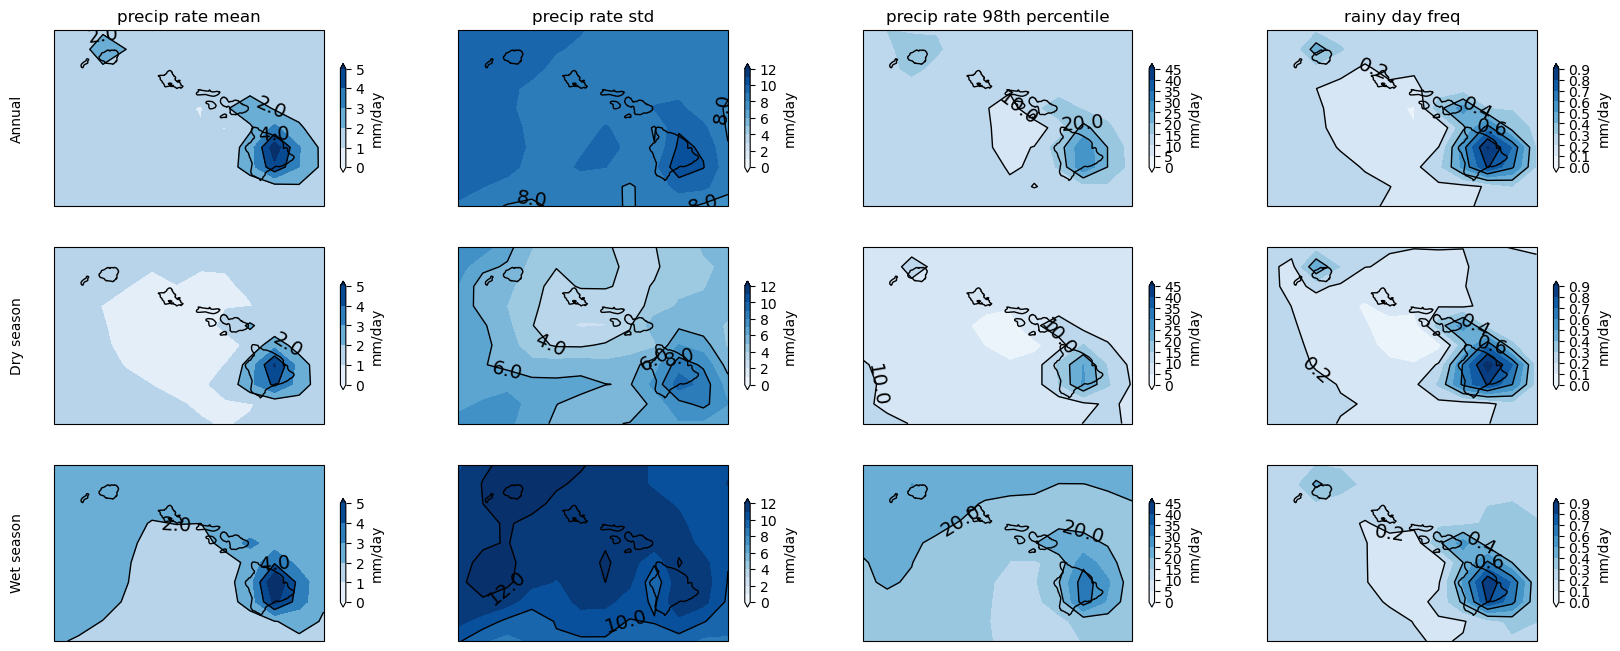

In [21]:
fig, axs = plt.subplots(3, 4, figsize=(20,8), subplot_kw=dict(projection=ccrs.PlateCarree()))
lat, lon = ds_gcm_historical_all.lat, ds_gcm_historical_all.lon
plot_contourf(ax=axs[0,0], lat=lat, lon=lon, data=gcm_historical_annual_precip_rate_mean, cmap='Blues', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[0,1], lat=lat, lon=lon, data=gcm_historical_annual_precip_rate_std, cmap='Blues', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[0,2], lat=lat, lon=lon, data=gcm_historical_annual_precip_rate_98, cmap='Blues', levels=np.arange(0, 50, 5), cbar_label='mm/day')
plot_contourf(ax=axs[0,3], lat=lat, lon=lon, data=gcm_historical_annual_rainy_day_freq, cmap='Blues', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')

plot_contourf(ax=axs[1,0], lat=lat, lon=lon, data=gcm_historical_dry_precip_rate_mean, cmap='Blues', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[1,1], lat=lat, lon=lon, data=gcm_historical_dry_precip_rate_std, cmap='Blues', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[1,2], lat=lat, lon=lon, data=gcm_historical_dry_precip_rate_98, cmap='Blues', levels=np.arange(0, 50, 5), cbar_label='mm/day')
plot_contourf(ax=axs[1,3], lat=lat, lon=lon, data=gcm_historical_dry_rainy_day_freq, cmap='Blues', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')

plot_contourf(ax=axs[2,0], lat=lat, lon=lon, data=gcm_historical_wet_precip_rate_mean, cmap='Blues', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[2,1], lat=lat, lon=lon, data=gcm_historical_wet_precip_rate_std, cmap='Blues', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[2,2], lat=lat, lon=lon, data=gcm_historical_wet_precip_rate_98, cmap='Blues', levels=np.arange(0, 50, 5), cbar_label='mm/day')
plot_contourf(ax=axs[2,3], lat=lat, lon=lon, data=gcm_historical_wet_rainy_day_freq, cmap='Blues', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')
[ax.coastlines() for ax in axs.flatten()]

geo_ylabel(axs[0,0], 'Annual')
geo_ylabel(axs[1,0], 'Dry season')
geo_ylabel(axs[2,0], 'Wet season')

fig.canvas.draw()
axs[0,0].set_title('precip rate mean')
axs[0,1].set_title('precip rate std')
axs[0,2].set_title('precip rate 98th percentile')
axs[0,3].set_title('rainy day freq')
pass

# GCM Future

In [23]:
ds_gcm_future = xr.open_dataset(f"{base_dir}/wasfia/GFDL_CM4C192_pr_hawaii_future_2015_2050.nc")
ds_gcm_future_all = ds_gcm_future.assign_coords(lon=(ds_gcm_future.lon + 180) % 360 - 180).sel(lat=hawaii_lat_bound, lon=hawaii_lon_bound)# "_all" as in all seasons
ds_gcm_future_dry = ds_gcm_future_all.sel(time=ds_gcm_future_all.time.dt.month.isin(dry_months))
ds_gcm_future_wet = ds_gcm_future_all.sel(time=ds_gcm_future_all.time.dt.month.isin(wet_months))

In [24]:
# annual mean
gcm_future_annual_precip_rate_mean = ds_gcm_future_all.mean(dim='time')['pr'].to_numpy()
gcm_future_annual_precip_rate_std = ds_gcm_future_all.std(dim='time')['pr'].to_numpy()
gcm_future_annual_precip_rate_98 = ds_gcm_future_all.quantile(dim='time', q=0.98)['pr'].to_numpy()
# seasonal mean (dry)
gcm_future_dry_precip_rate_mean = ds_gcm_future_dry.mean(dim='time')['pr'].to_numpy()
gcm_future_dry_precip_rate_std = ds_gcm_future_dry.std(dim='time')['pr'].to_numpy()
gcm_future_dry_precip_rate_98 = ds_gcm_future_dry.quantile(dim='time', q=0.98)['pr'].to_numpy()
# seasonal mean (wet)
gcm_future_wet_precip_rate_mean = ds_gcm_future_wet.mean(dim='time')['pr'].to_numpy()
gcm_future_wet_precip_rate_std = ds_gcm_future_wet.std(dim='time')['pr'].to_numpy()
gcm_future_wet_precip_rate_98 = ds_gcm_future_wet.quantile(dim='time', q=0.98)['pr'].to_numpy()

In [25]:
gcm_future_accum_precip_3_hourly = ds_gcm_future_all * (3 / 24)# convert rate (mm/day) to accumulation (mm over 3-hour)
gcm_future_accum_precip_daily = gcm_future_accum_precip_3_hourly.resample(time='1D').sum()

gcm_future_annual_rainy_day_freq = (gcm_future_accum_precip_daily > 1).mean(dim='time')['pr'].to_numpy()
gcm_future_dry_rainy_day_freq = (gcm_future_accum_precip_daily.sel(time=gcm_future_accum_precip_daily.time.dt.month.isin(dry_months)) > 1).mean(dim='time')['pr'].to_numpy()
gcm_future_wet_rainy_day_freq = (gcm_future_accum_precip_daily.sel(time=gcm_future_accum_precip_daily.time.dt.month.isin(wet_months)) > 1).mean(dim='time')['pr'].to_numpy()

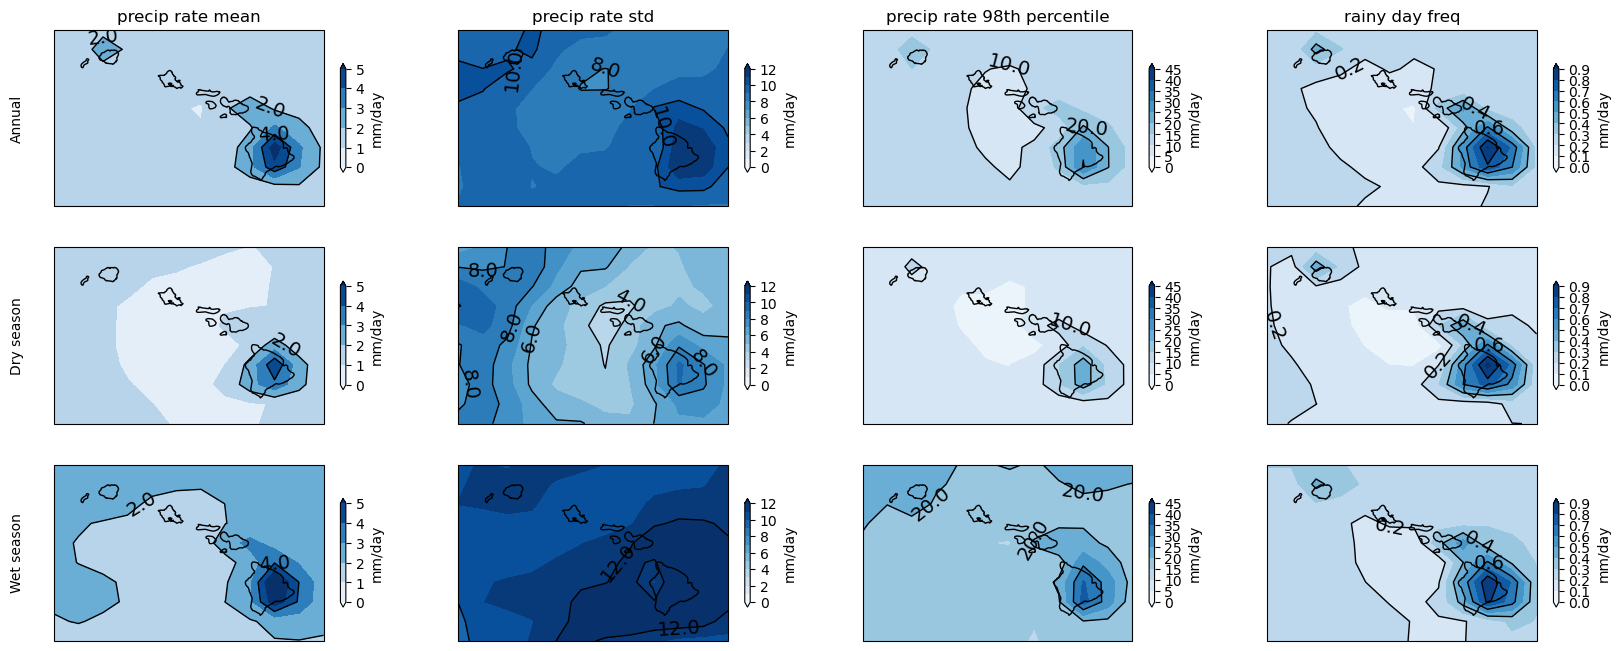

In [26]:
fig, axs = plt.subplots(3, 4, figsize=(20,8), subplot_kw=dict(projection=ccrs.PlateCarree()))
lat, lon = ds_gcm_historical_all.lat, ds_gcm_historical_all.lon
plot_contourf(ax=axs[0,0], lat=lat, lon=lon, data=gcm_future_annual_precip_rate_mean, cmap='Blues', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[0,1], lat=lat, lon=lon, data=gcm_future_annual_precip_rate_std, cmap='Blues', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[0,2], lat=lat, lon=lon, data=gcm_future_annual_precip_rate_98, cmap='Blues', levels=np.arange(0, 50, 5), cbar_label='mm/day')
plot_contourf(ax=axs[0,3], lat=lat, lon=lon, data=gcm_future_annual_rainy_day_freq, cmap='Blues', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')

plot_contourf(ax=axs[1,0], lat=lat, lon=lon, data=gcm_future_dry_precip_rate_mean, cmap='Blues', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[1,1], lat=lat, lon=lon, data=gcm_future_dry_precip_rate_std, cmap='Blues', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[1,2], lat=lat, lon=lon, data=gcm_future_dry_precip_rate_98, cmap='Blues', levels=np.arange(0, 50, 5), cbar_label='mm/day')
plot_contourf(ax=axs[1,3], lat=lat, lon=lon, data=gcm_future_dry_rainy_day_freq, cmap='Blues', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')

plot_contourf(ax=axs[2,0], lat=lat, lon=lon, data=gcm_future_wet_precip_rate_mean, cmap='Blues', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[2,1], lat=lat, lon=lon, data=gcm_future_wet_precip_rate_std, cmap='Blues', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[2,2], lat=lat, lon=lon, data=gcm_future_wet_precip_rate_98, cmap='Blues', levels=np.arange(0, 50, 5), cbar_label='mm/day')
plot_contourf(ax=axs[2,3], lat=lat, lon=lon, data=gcm_future_wet_rainy_day_freq, cmap='Blues', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')
[ax.coastlines() for ax in axs.flatten()]

geo_ylabel(axs[0,0], 'Annual')
geo_ylabel(axs[1,0], 'Dry season')
geo_ylabel(axs[2,0], 'Wet season')

fig.canvas.draw()
axs[0,0].set_title('precip rate mean')
axs[0,1].set_title('precip rate std')
axs[0,2].set_title('precip rate 98th percentile')
axs[0,3].set_title('rainy day freq')
pass